The 4 attacks defined in the paper are:
1. fixed amplitude fixed frequency sinusoidal signal
2. binarized version of the first
3. frequency hopping sinusoidal signal
4. binarized version of third
5. adding a gausian noise

In [1]:
import os
print(os.path.abspath("TESTING DOC_CV_page-0001.jpg"))


/home/khushi/TESTING DOC_CV_page-0001.jpg


In [28]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

image_path = "/home/khushi/Desktop/CV_Printer_Identification/Testing_images/TESTING_CV.jpg"
image = Image.open(image_path)

gray_array = np.array(image)

bit_depth = gray_array.dtype
image_mode = image.mode
image_shape = gray_array.shape

print(bit_depth, image_mode, image_shape)

uint8 RGB (1650, 1275, 3)


In [52]:
def save_image(array, name, directory):
    os.makedirs(directory, exist_ok=True)  # Create directory if it doesn't exist
    full_path = os.path.join(directory, name + ".jpg")  # Full path with filename
    img = Image.fromarray(np.clip(array, 0, 255).astype(np.uint8))
    img.save(full_path)

#Attack 1
def attack_fixed_freq(image, A, f, Rp):
    height, width = image.shape
    s1 = (A/2) * (1 + np.cos(2 * np.pi * f * np.arange(height)/Rp))
    
    s1 = s1[:, np.newaxis]
    attacked = np.where(image == 0, image+s1, 255)
    return attacked

#Attack 2
def attack_fixed_freq_binarized(image, A, f, Rp):
    height, width = image.shape
    s2 = (1/16) * (1 + np.cos(2 * np.pi * f * np.arange(height)/Rp))
    s2 = s2[:, np.newaxis]
    rand = np.random.rand(height, width)  # this is a random number for thresholding
    attacked = np.where((image == 0) & (rand < s2), 255, image)
    return attacked

#Attack 3
def attack_freq_hopping(image, A, Rp):
    height, width = image.shape
    phi = np.zeros(height)
    f_values = []
    alpha_values = []
    
    # Generate frequency segments
    i = 0
    while i < height:
        # Randomly select frequency and duration
        f = np.random.randint(30, 121)  # Frequency in [30,120]
        alpha = np.random.randint(0, 101)  # Duration in [0,100] rows
        alpha = max(1, alpha)  
        
        # Apply same frequency for alpha rows
        segment_end = min(i + alpha, height)
        for row in range(i, segment_end):
            if row == 0:
                phi[row] = 0      #phi(0) = 0 
            else:
                phi[row] = phi[row-1] + (2 * np.pi * f) / Rp
        
        i = segment_end
    
    s3 = (A / 2) * (1 + np.cos(phi))
    s3 = s3[:, np.newaxis]  
    attacked = np.where(image == 0, image + s3, 255)
    return attacked

#Attack 4
def attack_freq_hopping_binarized(image, Rp, nu=4):
    height, width = image.shape
    phi = np.zeros(height)
    f_values = []
    alpha_values = []
    
    # Generate frequency segments (same as Attack 3)
    i = 0
    while i < height:
        f = np.random.randint(30, 121)
        alpha = np.random.randint(0, 101)
        alpha = max(1, alpha)
        
        segment_end = min(i + alpha, height)
        for row in range(i, segment_end):
            if row == 0:
                phi[row] = 0
            else:
                phi[row] = phi[row-1] + (2 * np.pi * f) / Rp
        
        i = segment_end
    
    s4 = (1 / (2**nu)) * (1 + np.cos(phi))
    s4 = s4[:, np.newaxis]
    rand = np.random.rand(height, width)
    attacked = np.where((image == 0) & (rand < s4), 255, image)
    return attacked

#Attack 5
def attack_gaussian_noise(image, sigma = 5):
    height, width = image.shape
    noise = np.random.normal(3 * sigma/2, sigma, size=(height, width))
    attacked = np.where(image == 0, image+noise, image)
    return attacked
"""
Since using the condition was making the image worse, so I have just removed the condition and using the attack all over the image
"""
# def attack_fixed_freq_without_cond(image, A, f, Rp):
#     height, width = image.shape
#     s1 = (A/2) * (1 + np.cos(2 * np.pi * f * np.arange(height)/Rp))
#     s1 = s1[:, np.newaxis]
    
#     attacked = np.clip(image.astype(np.float32) + s1, 0, 255)
#     return attacked.astype(np.uint8)
def attack_fixed_freq_without_cond(image, A, f, Rp):
    height, width = image.shape
    
    # Create cosine signal across rows
    s1 = (A / 2) * (1 + np.cos(2 * np.pi * f * np.arange(height) / Rp))
    s1 = s1[:, np.newaxis]  # Reshape for broadcasting
    weight = 1 - (image.astype(np.float32) / 255.0)
    
    # Apply dynamic scaling based on intensity
    modified = image.astype(np.float32) + (s1 * weight)
    attacked = np.clip(modified, 0, 255).astype(np.uint8)    
    return attacked


def attack_freq_hoppingwithout_cond(image, A, Rp):
    height, width = image.shape
    phi = np.zeros(height)
    
    i = 0
    while i < height:
        # Random frequency in [30, 120] and segment length [1, 100]
        f = np.random.randint(30, 121)
        alpha = max(1, np.random.randint(0, 101))
        
        segment_end = min(i + alpha, height)
        for row in range(i, segment_end):
            if row == 0:
                phi[row] = 0
            else:
                phi[row] = phi[row - 1] + (2 * np.pi * f) / Rp
        i = segment_end

    s3 = (A / 2) * (1 + np.cos(phi))
    s3 = s3[:, np.newaxis] 

    # Apply attack using np.clip for smooth integration
    attacked = np.clip(image.astype(np.float32) + s3, 0, 255)
    return attacked.astype(np.uint8)

In [59]:
image_path = "/home/khushi/Desktop/CV_Printer_Identification/Dataset_OG/banded_image_10_0.04.jpg"
og_img = Image.open(image_path).convert("L")
gray = np.array(og_img)

#setting the parameters
A = 0.01
f = 2
Rp = 500   
""" 
I have one doubt here Rp is a scaling factor that maintain the consistenncy between the digital attack and printing
So should Rp will vary acc to teh printer for each case or it will be fixed accoridn to scanner as finally it is goign to be scanned at last
"""

att1 = attack_fixed_freq(gray, A, f, Rp)
att2 = attack_fixed_freq_binarized(gray, A, f, Rp)
att3 = attack_freq_hopping(gray, A, Rp)
att4 = attack_freq_hopping_binarized(gray, Rp)
att5 = attack_gaussian_noise(gray)
att1_1 = attack_fixed_freq(gray, A, f, Rp)
att3_1 = attack_freq_hopping(gray, A, Rp)

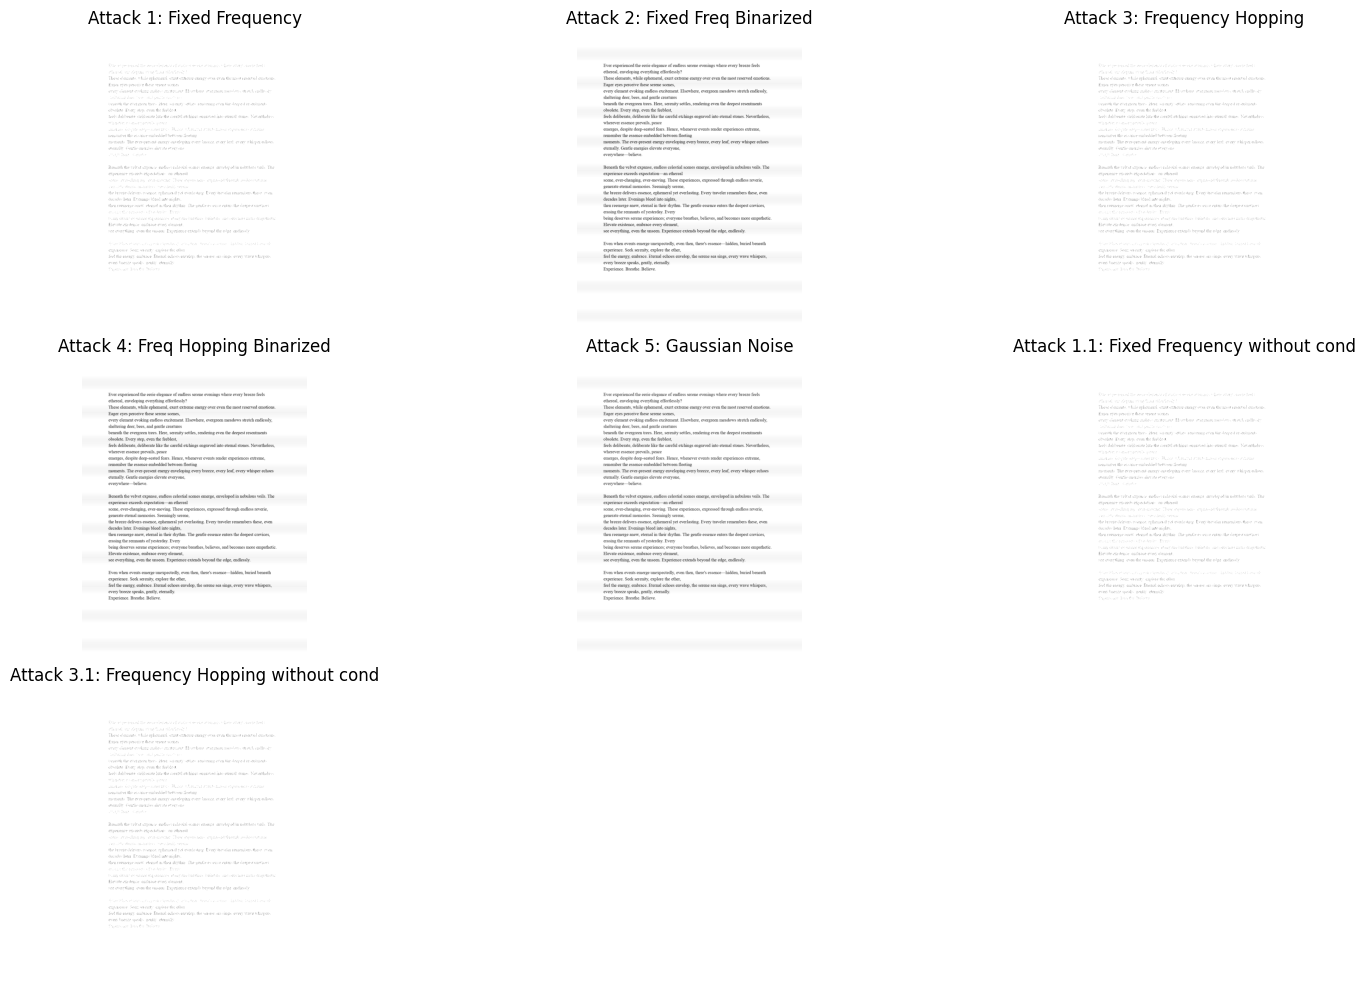

In [60]:
import matplotlib.pyplot as plt

attacks = [
    (att1, "Attack 1: Fixed Frequency"),
    (att2, "Attack 2: Fixed Freq Binarized"),
    (att3, "Attack 3: Frequency Hopping"),
    (att4, "Attack 4: Freq Hopping Binarized"),
    (att5, "Attack 5: Gaussian Noise"),
    (att1_1, "Attack 1.1: Fixed Frequency without cond"),
    (att3_1, "Attack 3.1: Frequency Hopping without cond")
]

# Plotting
plt.figure(figsize=(15, 10))
for i, (img, title) in enumerate(attacks, 1):
    plt.subplot(3, 3, i)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

target_dir = "/home/khushi/Desktop/CV_Printer_Identification/Testing_Dataset/banded_image_10_0.04"

save_image(att1, "attack_fixed_freq_0.01_2_500", target_dir)
save_image(att2, "attack_fixed_freq_binarized_0.01_2_500", target_dir)
save_image(att3, "attack_freq_hopping_0.01_2_500", target_dir)
save_image(att4, "attack_freq_hopping_binarized_0.01_2_500", target_dir)
save_image(att5, "attack_gaussian_noise_0.01_2_500", target_dir)
save_image(att1_1, "attack_fixed_freq_without_cond_0.01_2_500", target_dir)
save_image(att3_1, "attack_freq_hopping_without_cond_0.01_2_500", target_dir)